In [402]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from datetime import datetime
import random
import warnings
warnings.filterwarnings('ignore')

def predict_next_moves():
    # Load the data
    try:
        df = pd.read_csv("E:/Review2 godot projects_AshwinRavi/Dataset/Hanoi_2.csv")
    except Exception as e:
        print(f"Error: Could not load Hanoi_2.csv file: {e}")
        return
    
    # Skip timestamp processing entirely
    df = df.reset_index(drop=True)
    
    # Generate a new random seed every time the function is run
    random_seed = int(datetime.now().timestamp() % 10000)
    np.random.seed(random_seed)
    random.seed(random_seed)
    
    # Process player data
    player_stats = {}
    for player in df['Player'].unique():
        player_df = df[df['Player'] == player].copy()
        
        # Add some randomness - sample 80-100% of player data for training
        sample_rate = random.uniform(0.8, 1.0)
        sample_size = max(1, int(len(player_df) * sample_rate))
        player_df = player_df.sample(sample_size, random_state=random_seed).sort_index()
        
        # Create features
        player_df['MovesOverMin'] = player_df['Moves Taken'] - player_df['Minimum Moves']
        player_df['EfficiencyRatio'] = player_df['Minimum Moves'] / player_df['Moves Taken']
        player_df['Success'] = (player_df['Solution Status'] == 'Solved!').astype(int)
        
        # Calculate statistics based on previous games
        player_df['avg_moves_over_min'] = player_df['MovesOverMin'].expanding().mean().shift(1)
        player_df['success_rate'] = player_df['Success'].expanding().mean().shift(1)
        player_df['avg_efficiency'] = player_df['EfficiencyRatio'].expanding().mean().shift(1)
        
        # Add some noise to the features to make predictions dynamic
        player_df['avg_moves_over_min'] = player_df['avg_moves_over_min'].fillna(0) * random.uniform(0.95, 1.05)
        player_df['success_rate'] = player_df['success_rate'].fillna(0.5) * random.uniform(0.95, 1.05)
        player_df['avg_efficiency'] = player_df['avg_efficiency'].fillna(1.0) * random.uniform(0.95, 1.05)
        
        player_stats[player] = player_df

    # Prepare features and target for each player
    predictions = {}
    
    for player, player_df in player_stats.items():
        if len(player_df) <= 1:
            print(f"Not enough data for player {player}. Skipping predictions.")
            continue
            
        # Features: current difficulty (disks), historical performance
        X = player_df[['Disks', 'avg_moves_over_min', 'success_rate', 'avg_efficiency']].values
        
        # Target: moves taken
        y = player_df['Moves Taken'].values
        
        # Add small random noise to training data
        X = X + np.random.normal(0, 0.05, X.shape)
        y = y * np.random.uniform(0.98, 1.02, y.shape)
        
        # Scale features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        # Dynamic model parameters
        dt_depth = random.randint(3, 7)
        svm_c = random.uniform(50, 150)
        svm_gamma = random.uniform(0.05, 0.15)
        
        # Train Decision Tree model with dynamic parameters
        dt_model = DecisionTreeRegressor(max_depth=dt_depth, random_state=random_seed)
        dt_model.fit(X_scaled, y)
        
        # Train SVM model with dynamic parameters
        svm_model = SVR(kernel='rbf', C=svm_c, gamma=svm_gamma)
        svm_model.fit(X_scaled, y)
        
        # Get unique disk counts and sort them
        unique_disks = sorted(player_df['Disks'].unique())
        
        # Get the latest stats for the player with slight randomness
        latest_avg_moves_over_min = player_df['avg_moves_over_min'].iloc[-1] * random.uniform(0.97, 1.03)
        latest_success_rate = player_df['success_rate'].iloc[-1] * random.uniform(0.97, 1.03)
        latest_avg_efficiency = player_df['avg_efficiency'].iloc[-1] * random.uniform(0.97, 1.03)
        
        # Make predictions for the next 10 games
        dt_predictions = []
        svm_predictions = []
        remark_list = []
        
        # Start from a random disk count
        if len(unique_disks) > 0:
            start_disk = random.choice(unique_disks)
            disk_index = unique_disks.index(start_disk)
        else:
            # Fallback if no disk data
            disk_index = 0
            unique_disks = [3] # Default to 3 disks
        
        for i in range(10):
            # Dynamic disk progression - sometimes increment, sometimes random
            if random.random() < 0.7:  # 70% chance to follow sequence
                next_disk = unique_disks[(disk_index + i) % len(unique_disks)]
            else:  # 30% chance to pick random disk
                next_disk = random.choice(unique_disks)
            
            # Create feature vector for prediction with slight randomness
            X_pred = np.array([[
                next_disk,
                latest_avg_moves_over_min * random.uniform(0.98, 1.02),
                latest_success_rate * random.uniform(0.98, 1.02),
                latest_avg_efficiency * random.uniform(0.98, 1.02)
            ]])
            X_pred_scaled = scaler.transform(X_pred)
            
            # Add small random variation to predictions
            variation_factor = random.uniform(0.97, 1.03)
            
            # Make predictions
            dt_pred = dt_model.predict(X_pred_scaled)[0] * variation_factor
            svm_pred = svm_model.predict(X_pred_scaled)[0] * variation_factor
            
            # Ensure predictions are not negative or decimal
            dt_pred = max(1, int(round(dt_pred)))
            svm_pred = max(1, int(round(svm_pred)))
            
            # Calculate minimum moves for this disk count (2^n - 1)
            min_moves = 2**next_disk - 1
            
            # Keep predictions sensible - not less than minimum required
            dt_pred = max(dt_pred, min_moves)
            svm_pred = max(svm_pred, min_moves)
            
            # Add small variation to final predictions
            dt_pred += random.randint(-2, 2)
            svm_pred += random.randint(-2, 2)
            
            # Ensure predictions remain at or above minimum
            dt_pred = max(dt_pred, min_moves)
            svm_pred = max(svm_pred, min_moves)
            
            # Add to prediction lists
            dt_predictions.append(dt_pred)
            svm_predictions.append(svm_pred)
            
            # Determine remark based on predicted performance - using only "Solved!" or "Keep trying"
            success_probability = 1.0 if dt_pred == min_moves else 0.8 if dt_pred <= min_moves + 2 else 0.5 if dt_pred <= min_moves + 5 else 0.2
            
            # Add randomness to prediction - even perfect solutions might not be marked as solved
            if random.random() < success_probability:
                remark = "Solved!"
            else:
                remark = "Keep trying"
                
            remark_list.append(remark)
        
        # Store predictions
        predictions[player] = {
            'disks': [unique_disks[(disk_index + i) % len(unique_disks)] for i in range(10)],
            'dt_predictions': dt_predictions,
            'svm_predictions': svm_predictions,
            'remarks': remark_list,
            'min_moves': [2**unique_disks[(disk_index + i) % len(unique_disks)] - 1 for i in range(10)]
        }
    
    # Print predictions with a runtime timestamp to show it's dynamic
    current_time = datetime.now().strftime("%H:%M:%S")
    print(f"\n--- Tower of Hanoi Move Predictions (Run at: {current_time}) ---\n")
    
    for player, pred_data in predictions.items():
        print(f"Player: {player}")
        print("=" * 70)
        print(f"{'Game':^5} | {'Disks':^5} | {'Min Moves':^9} | {'DT Pred':^7} | {'SVM Pred':^8} | {'Remark'}")
        print("-" * 70)
        
        for i in range(10):
            print(f"{i+1:^5} | {pred_data['disks'][i]:^5} | {pred_data['min_moves'][i]:^9} | {pred_data['dt_predictions'][i]:^7} | {pred_data['svm_predictions'][i]:^8} | {pred_data['remarks'][i]}")
        
        print("\n")
    
    return predictions

# Run the function to make predictions
if __name__ == "__main__":
    predict_next_moves()


--- Tower of Hanoi Move Predictions (Run at: 21:01:19) ---

Player: Max
Game  | Disks | Min Moves | DT Pred | SVM Pred | Remark
----------------------------------------------------------------------
  1   |   8   |    255    |   262   |   255    | Solved!
  2   |   9   |    511    |   68    |    93    | Keep trying
  3   |  10   |   1023    |   520   |   512    | Keep trying
  4   |   3   |     7     |   17    |    19    | Keep trying
  5   |   4   |    15     |   16    |    29    | Solved!
  6   |   5   |    31     |   36    |    53    | Keep trying
  7   |   6   |    63     |  1066   |   1023   | Keep trying
  8   |   7   |    127    |   139   |   136    | Keep trying
  9   |   8   |    255    |   72    |    90    | Solved!
 10   |   9   |    511    |   520   |   513    | Solved!


Player: Ash
Game  | Disks | Min Moves | DT Pred | SVM Pred | Remark
----------------------------------------------------------------------
  1   |   7   |    127    |   137   |   227    | Solved!
  2   | 

In [405]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.svm import SVR, SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from datetime import datetime
import random
import warnings

warnings.filterwarnings('ignore')

def predict_next_moves():
    try:
        df = pd.read_csv("E:/Review2 godot projects_AshwinRavi/Dataset/Hanoi_2.csv")
    except Exception as e:
        print(f"Error: Could not load Hanoi_2.csv file: {e}")
        return
    
    df = df.reset_index(drop=True)

    # **Convert Solution Status into Labels**
    df["Solution Status"] = df["Solution Status"].map({"Solved!": 1, "Keep trying": 0})

    # **Feature Engineering**
    df["MovesOverMin"] = df["Moves Taken"] - df["Minimum Moves"]
    df["EfficiencyRatio"] = df["Minimum Moves"] / df["Moves Taken"]

    # **Define Features & Labels for Classification**
    X = df[["Disks", "Moves Taken"]]
    y = df["Solution Status"]

    # **Split Data for Training & Testing**
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # **Train Decision Tree Classifier**
    dt_classifier = DecisionTreeClassifier(random_state=42)
    dt_classifier.fit(X_train, y_train)
    y_pred_dt = dt_classifier.predict(X_test)

    # **Train SVM Classifier**
    svm_classifier = SVC(kernel='rbf', class_weight='balanced', random_state=42)
    svm_classifier.fit(X_train, y_train)
    y_pred_svm = svm_classifier.predict(X_test)

    # **Decision Tree Classification Report**
    accuracy_dt = accuracy_score(y_test, y_pred_dt)
    report_dt = classification_report(y_test, y_pred_dt, target_names=["Keep trying", "Solved!"])

    print(f"Accuracy (Decision Tree): {accuracy_dt:.2f}")
    print("Classification Report for Decision Tree:")
    print(report_dt)

    # **SVM Classification Report**
    accuracy_svm = accuracy_score(y_test, y_pred_svm)
    report_svm = classification_report(y_test, y_pred_svm, target_names=["Keep trying", "Solved!"])

    print(f"Accuracy (SVM): {accuracy_svm:.2f}")
    print("Classification Report for SVM:")
    print(report_svm)

predict_next_moves()



Accuracy (Decision Tree): 0.95
Classification Report for Decision Tree:
              precision    recall  f1-score   support

 Keep trying       0.94      1.00      0.97        17
     Solved!       1.00      0.75      0.86         4

    accuracy                           0.95        21
   macro avg       0.97      0.88      0.91        21
weighted avg       0.96      0.95      0.95        21

Accuracy (SVM): 0.43
Classification Report for SVM:
              precision    recall  f1-score   support

 Keep trying       0.86      0.35      0.50        17
     Solved!       0.21      0.75      0.33         4

    accuracy                           0.43        21
   macro avg       0.54      0.55      0.42        21
weighted avg       0.73      0.43      0.47        21



Accuracy (Decision Tree): 0.95
Classification Report for Decision Tree:
              precision    recall  f1-score   support

 Keep trying       0.94      1.00      0.97        17
     Solved!       1.00      0.75      0.86         4

    accuracy                           0.95        21
   macro avg       0.97      0.88      0.91        21
weighted avg       0.96      0.95      0.95        21

Accuracy (SVM): 0.43
Classification Report for SVM:
              precision    recall  f1-score   support

 Keep trying       0.86      0.35      0.50        17
     Solved!       0.21      0.75      0.33         4

    accuracy                           0.43        21
   macro avg       0.54      0.55      0.42        21
weighted avg       0.73      0.43      0.47        21



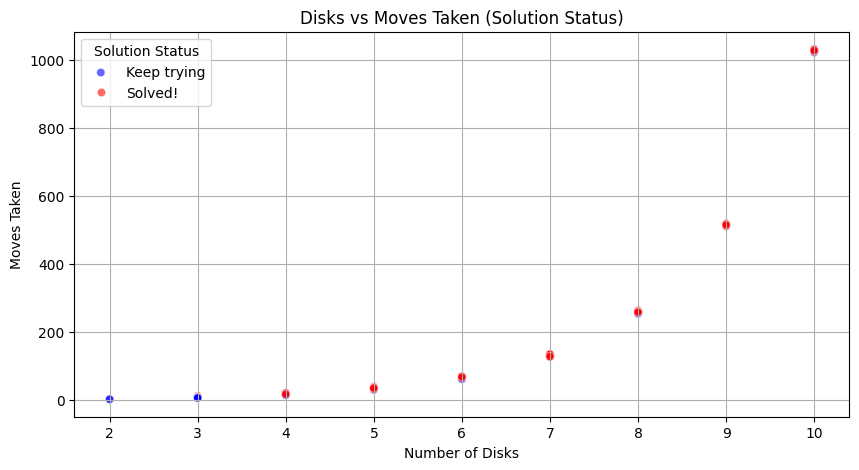

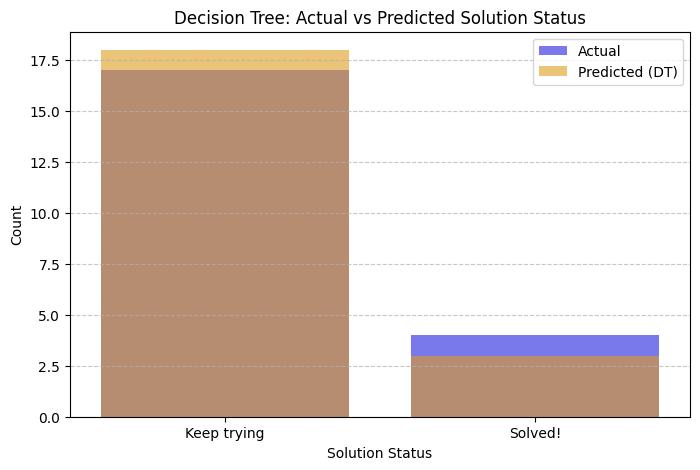

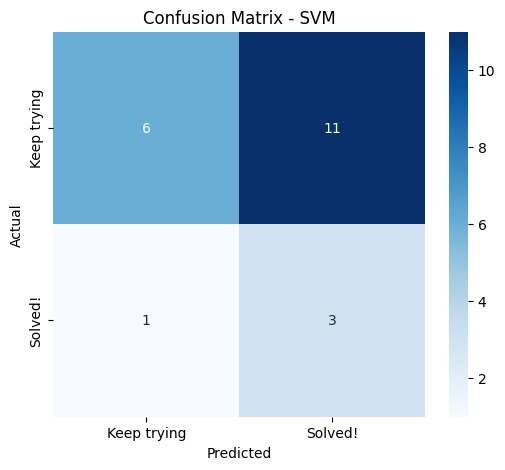

In [406]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

def predict_next_moves():
    try:
        df = pd.read_csv("E:/Review2 godot projects_AshwinRavi/Dataset/Hanoi_2.csv")
    except Exception as e:
        print(f"Error: Could not load Hanoi_2.csv file: {e}")
        return
    
    df = df.reset_index(drop=True)

    # **Convert Solution Status into Labels**
    df["Solution Status"] = df["Solution Status"].map({"Solved!": 1, "Keep trying": 0})

    # **Feature Engineering**
    df["MovesOverMin"] = df["Moves Taken"] - df["Minimum Moves"]
    df["EfficiencyRatio"] = df["Minimum Moves"] / df["Moves Taken"]

    # **Define Features & Labels for Classification**
    X = df[["Disks", "Moves Taken"]]
    y = df["Solution Status"]

    # **Split Data for Training & Testing**
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # **Train Decision Tree Classifier**
    dt_classifier = DecisionTreeClassifier(random_state=42)
    dt_classifier.fit(X_train, y_train)
    y_pred_dt = dt_classifier.predict(X_test)

    # **Train SVM Classifier**
    svm_classifier = SVC(kernel='rbf', class_weight='balanced', random_state=42)
    svm_classifier.fit(X_train, y_train)
    y_pred_svm = svm_classifier.predict(X_test)

    # **Decision Tree Classification Report**
    accuracy_dt = accuracy_score(y_test, y_pred_dt)
    report_dt = classification_report(y_test, y_pred_dt, target_names=["Keep trying", "Solved!"])

    print(f"Accuracy (Decision Tree): {accuracy_dt:.2f}")
    print("Classification Report for Decision Tree:")
    print(report_dt)

    # **SVM Classification Report**
    accuracy_svm = accuracy_score(y_test, y_pred_svm)
    report_svm = classification_report(y_test, y_pred_svm, target_names=["Keep trying", "Solved!"])

    print(f"Accuracy (SVM): {accuracy_svm:.2f}")
    print("Classification Report for SVM:")
    print(report_svm)

    # **🔹 1️⃣ Scatter Plot: Disks vs Moves Taken Colored by Solution Status**
    plt.figure(figsize=(10, 5))
    sns.scatterplot(x=df["Disks"], y=df["Moves Taken"], hue=df["Solution Status"], palette={1: "blue", 0: "red"}, alpha=0.6)
    plt.title("Disks vs Moves Taken (Solution Status)")
    plt.xlabel("Number of Disks")
    plt.ylabel("Moves Taken")
    plt.legend(["Keep trying", "Solved!"], title="Solution Status")
    plt.grid()
    plt.show()

    # **🔹 2️⃣ Bar Plot: Actual vs Predicted Solution Status (Decision Tree)**
    plt.figure(figsize=(8, 5))
    sns.countplot(x=y_test, label="Actual", color="blue", alpha=0.6)
    sns.countplot(x=y_pred_dt, label="Predicted (DT)", color="orange", alpha=0.6)
    plt.title("Decision Tree: Actual vs Predicted Solution Status")
    plt.xlabel("Solution Status")
    plt.ylabel("Count")
    plt.legend()
    plt.xticks(ticks=[0, 1], labels=["Keep trying", "Solved!"])
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

    # **🔹 3️⃣ Confusion Matrix for SVM**
    cm_svm = confusion_matrix(y_test, y_pred_svm)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_svm, annot=True, fmt="d", cmap="Blues", xticklabels=["Keep trying", "Solved!"], yticklabels=["Keep trying", "Solved!"])
    plt.title("Confusion Matrix - SVM")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

predict_next_moves()


<Figure size 1000x500 with 0 Axes>

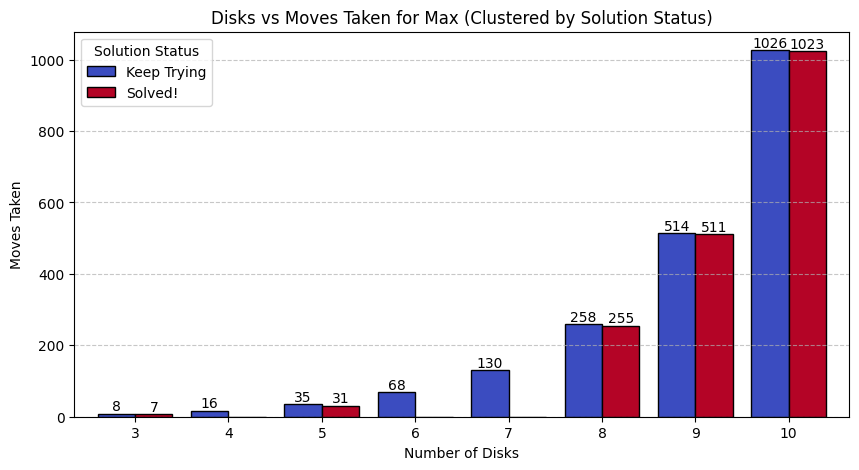

<Figure size 1000x500 with 0 Axes>

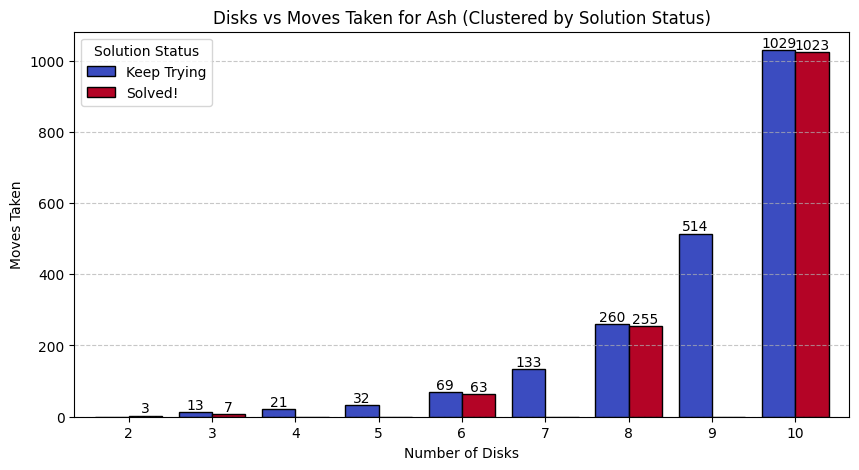

<Figure size 1000x500 with 0 Axes>

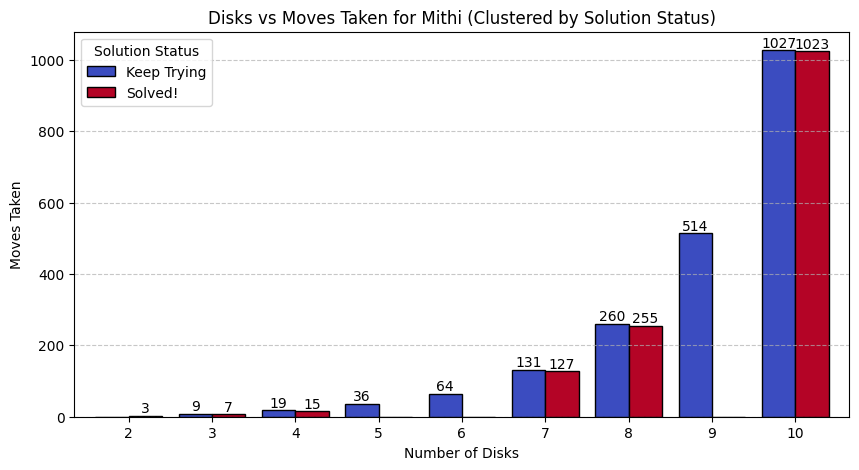

In [414]:
# **Ensure Player Names are Decoded**
df["Player Name"] = label_encoder.inverse_transform(df["Player"])  # Convert IDs to Names

# **Create Player-Specific Clustered Bar Charts for Disks vs Moves Taken**
for player in df["Player"].unique():
    player_name = label_encoder.inverse_transform([player])[0]  # Convert ID to Name
    player_data = df[df["Player"] == player]  # Filter data for this player

    # **Group by Disks and Solution Status, then calculate average moves taken**
    grouped_data = player_data.groupby(["Disks", "Solution Status"])["Moves Taken"].mean().unstack()

    # **Plot the clustered bar chart**
    plt.figure(figsize=(10, 5))
    grouped_data.plot(kind="bar", colormap="coolwarm", width=0.8, edgecolor="black", figsize=(10, 5))

    # **Set Titles and Labels**
    plt.title(f"Disks vs Moves Taken for {player_name} (Clustered by Solution Status)")
    plt.xlabel("Number of Disks")
    plt.ylabel("Moves Taken")
    plt.legend(title="Solution Status", labels=["Keep Trying", "Solved!"])
    plt.xticks(rotation=0)

    # **Display Values on Bars**
    ax = plt.gca()
    for p in ax.patches:
        height = p.get_height()
        if height > 0:
            ax.annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2, height), 
                        ha='center', va='bottom', fontsize=10)

    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()


